In [6]:
from functools import reduce
def convex_hull_graham(points):

    TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)

    def cmp(a, b):
        return (a > b) - (a < b)

    def turn(p, q, r):
        return cmp((q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1]), 0)

    def _keep_left(hull, r):
        while len(hull) > 1 and turn(hull[-2], hull[-1], r) != TURN_LEFT:
            hull.pop()
        if not len(hull) or hull[-1] != r:
            hull.append(r)
        #print("r ", r)    
        #print(hull)    
        return hull

    points = sorted(points)
    l = reduce(_keep_left, points, [])
    #print('L')
    #print(l)
    u = reduce(_keep_left, reversed(points), [])
    return l.extend(u[i] for i in range(1, len(u) - 1)) or l

In [32]:
from math import sqrt
import time
from queue import PriorityQueue
from math import inf

def _point_to_polygon_distance(x, y, polygon):
    inside = False
    min_dist_sq = inf

    for ring in polygon:
        b = ring[-1]
        for a in ring:

            if ((a[1] > y) != (b[1] > y) and
                    (x < (b[0] - a[0]) * (y - a[1]) / (b[1] - a[1]) + a[0])):
                inside = not inside

            min_dist_sq = min(min_dist_sq, _get_seg_dist_sq(x, y, a, b))
            b = a

    result = sqrt(min_dist_sq)
    if not inside:
        return -result
    return result


def _get_seg_dist_sq(px, py, a, b):
    x = a[0]
    y = a[1]
    dx = b[0] - x
    dy = b[1] - y

    if dx != 0 or dy != 0:
        t = ((px - x) * dx + (py - y) * dy) / (dx * dx + dy * dy)

        if t > 1:
            x = b[0]
            y = b[1]

        elif t > 0:
            x += dx * t
            y += dy * t

    dx = px - x
    dy = py - y

    return dx * dx + dy * dy


class Cell(object):
    def __init__(self, x, y, h, polygon):
        self.h = h
        self.y = y
        self.x = x
        self.d = _point_to_polygon_distance(x, y, polygon)
        self.max = self.d + self.h * sqrt(2)

    def __lt__(self, other):
        return self.max < other.max

    def __lte__(self, other):
        return self.max <= other.max

    def __gt__(self, other):
        return self.max > other.max

    def __gte__(self, other):
        return self.max >= other.max

    def __eq__(self, other):
        return self.max == other.max


def _get_centroid_cell(polygon):
    area = 0
    x = 0
    y = 0
    points = polygon[0]
    b = points[-1]  # prev
    for a in points:
        f = a[0] * b[1] - b[0] * a[1]
        x += (a[0] + b[0]) * f
        y += (a[1] + b[1]) * f
        area += f * 3
        b = a
    if area == 0:
        return Cell(points[0][0], points[0][1], 0, polygon)
    return Cell(x / area, y / area, 0, polygon)

    pass


def polylabel(polygon, precision=1, debug=False, with_distance=False):
    first_item = polygon[0][0]
    min_x = first_item[0]
    min_y = first_item[1]
    max_x = first_item[0]
    max_y = first_item[1]
    for p in polygon[0]:
        if p[0] < min_x:
            min_x = p[0]
        if p[1] < min_y:
            min_y = p[1]
        if p[0] > max_x:
            max_x = p[0]
        if p[1] > max_y:
            max_y = p[1]

    width = max_x - min_x
    height = max_y - min_y
    cell_size = min(width, height)
    h = cell_size / 2.0

    cell_queue = PriorityQueue()

    if cell_size == 0:
        if with_distance:
            return [min_x, min_y], None
        else:
            return [min_x, min_y]

    x = min_x
    while x < max_x:
        y = min_y
        while y < max_y:
            c = Cell(x + h, y + h, h, polygon)
            y += cell_size
            cell_queue.put((-c.max, time.time(), c))
        x += cell_size

    best_cell = _get_centroid_cell(polygon)

    bbox_cell = Cell(min_x + width / 2, min_y + height / 2, 0, polygon)
    if bbox_cell.d > best_cell.d:
        best_cell = bbox_cell

    num_of_probes = cell_queue.qsize()
    print("size initial: ", num_of_probes)
    i=0
    while not cell_queue.empty():
        _, __, cell = cell_queue.get()
        i+=1

        if cell.d > best_cell.d:
            best_cell = cell

            if debug:
                print('found best {} after {} probes'.format(
                    round(1e4 * cell.d) / 1e4, num_of_probes))

        if cell.max - best_cell.d <= precision:
            continue

        h = cell.h / 2
        c = Cell(cell.x - h, cell.y - h, h, polygon)
        cell_queue.put((-c.max, time.time(), c))
        c = Cell(cell.x + h, cell.y - h, h, polygon)
        cell_queue.put((-c.max, time.time(), c))
        c = Cell(cell.x - h, cell.y + h, h, polygon)
        cell_queue.put((-c.max, time.time(), c))
        c = Cell(cell.x + h, cell.y + h, h, polygon)
        cell_queue.put((-c.max, time.time(), c))
        num_of_probes += 4
        

    if debug:
        print('num probes: {}'.format(num_of_probes))
        print('best distance: {}'.format(best_cell.d))
        print("i ", i)
    if with_distance:
        return [best_cell.x, best_cell.y], best_cell.d
    else:
        return [best_cell.x, best_cell.y]

In [33]:
import random
import ast
import matplotlib.pyplot as plt
import matplotlib

def initial():
    print('random or handmade points?')
    ans=input()
    if ans=='random':
        print('enter amount of points')
        amo=int(input())
    if ans=='handmade':
        print('enter points')
        amo=input()
    return(ans,amo) 


    
def work(pts):
#pts=random.sample([[x, y] for x in range(101) for y in range(101)], 1000)   
    res = convex_hull_graham(pts)
    #print(pts)

    res.append(res[0])
    circle=polylabel([res], debug=True,with_distance=True) 

    fig, ax = plt.subplots(figsize=(15,15))
    ax.set(xlim=(-10, 1100), ylim = (-10, 1100))
    a_circle = plt.Circle((circle[0][0], circle[0][1]), circle[1], color='red', fill=False)
    ax.add_artist(a_circle)
    ax.plot(*zip(*res))
    ax.scatter(*zip(*pts))
    ax.scatter(circle[0][0], circle[0][1], color='red')
    
    
    
    

random or handmade points?
random
enter amount of points
100
size initial:  2
num probes: 130
best distance: 483.2446560978874
i  130


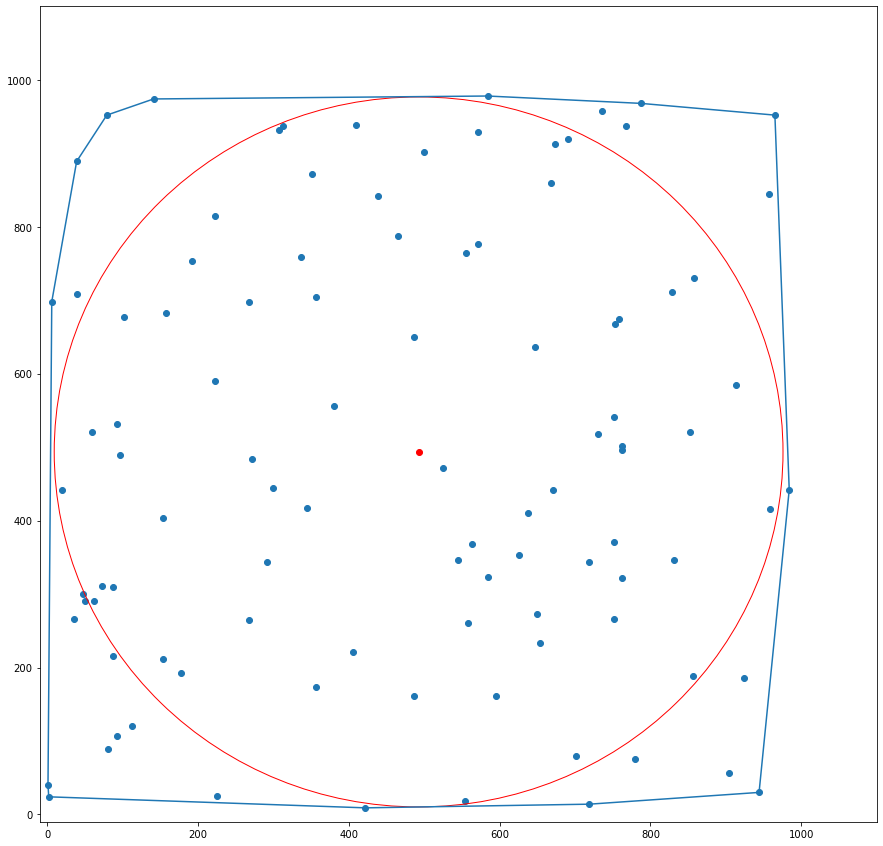

In [34]:
ans,amo=initial()
if ans=='random':
        pts=random.sample([[x, y] for x in range(1001) for y in range(1001)], amo) 
if ans=='handmade':
        print('enter points')
        pts= ast.literal_eval(amo)
#pts=random.sample([[x, y] for x in range(101) for y in range(101)], 100)
#pts = [(-12.470748246261751, -0.48488934088636171), (-12.483424095180279, -0.28151481232649189), (-12.488162156460632, -0.20108200880463656), (-12.497370509189397, -0.040216401760925891), (-12.497370509189397, 0.040216401760925891), (-12.488162156460634, 0.20108200880463656), (-12.483424095180281, 0.28151481232649544), (-12.413228308823713, 1.4075740616324666), (-12.403180595377217, 1.5684396686761772), (-12.39171475878355, 1.6488724721980326), (-12.390291805963288, 1.6579213160312198), (-12.378634187438472, 1.7293052757198879), (-12.120280921430131, 3.0966629355914286), (-12.103023997423247, 3.1770957391132839), (-12.055086188086673, 3.3379613461569946), (-12.030998755288378, 3.4183941496788464), (-11.69463042306316, 4.4640205954629693), (-11.666183843277125, 4.5516760010157151), (-11.61622884175913, 4.7053190060285353), (-11.585727402978661, 4.7842582827862712), (-11.424814522381737, 5.1299386591368323), (-11.022532320889418, 5.9939930554624175), (-10.984756620485475, 6.0726766659000759), (-10.861619440292493, 6.3053146373453526), (-10.856730634642656, 6.3139750764656384), (-10.200848478575528, 7.3596015222497542), (-10.147974462654739, 7.4400343257716131), (-10.041424410566105, 7.6008999328153255), (-9.9798921926331001, 7.6813327363371773), (-9.1720341940247732, 8.6707519554765149), (-9.1227134683574338, 8.7269591821212966), (-8.9782627276517069, 8.8878247891650073), (-8.9306648731293858, 8.9368420932649695), (-7.9651875895478259, 9.8573941650236776), (-7.8847311492493635, 9.9323912006499153), (-7.804274708950901, 9.9970380395096274), (-6.7583409850708858, 10.771058207072169), (-6.6944181612869329, 10.818212073689537), (-6.5851255856541888, 10.898644877211389), (-6.5169716641754967, 10.938410911978798), (-6.3560587835785682, 11.03079037025697), (-6.3055314924059775, 11.0595104842551), (-5.3050686899873538, 11.622540108908089), (-5.2296686194000905, 11.662085197184643), (-5.0687557388031674, 11.737702650674365), (-4.9882992985047032, 11.774526483488115), (-3.9423655746246826, 12.202140849815269), (-3.7009962537292918, 12.300516546391181), (-3.6205398134308293, 12.325930245785131), (-3.5400833731323669, 12.348950729943816), (-3.4596269328339062, 12.371406201160964), (-2.3600484750236386, 12.668166554692206), (-2.333236768655425, 12.67528391485475), (-2.1723238880585001, 12.717906297182143), (-2.0918674477600341, 12.738142066804299), (-1.8504981268646468, 12.773229783612351), (-1.7700416865661825, 12.784523705881448), (-0.80456440298463328, 12.919704714360721), (-0.72410796268616728, 12.930904093550648), (-0.5631950820892424, 12.95322758072205), (-0.48273864179077997, 12.960317712449569), (-0.32182576119385331, 12.964500861663005), (-0.24136932089539087, 12.966339904213372), (1.0459337238800188, 12.985157455012546), (1.1263901641784813, 12.980195032529037), (1.2873030447754061, 12.966804357671618), (1.3677594850738721, 12.958783451171877), (2.5746060895508087, 12.825641205913508), (2.6550625298492747, 12.815951435775206), (2.896431850744662, 12.768150656697392), (2.9791303857985962, 12.748599358214065), (4.1837348955200717, 12.460987097939352), (4.2641913358185342, 12.438164794670618), (4.4251042164154626, 12.384183086040222), (4.505560656713925, 12.356125708713449), (5.5514943805939438, 11.963779719423489), (5.7928637014893276, 11.872412809642093), (5.8138774411022727, 11.863838519473653), (5.87332014178779, 11.834256863731449), (7.0801667462647355, 11.200794258055343), (7.160623186563198, 11.15616134098266), (7.3221447647079003, 11.0595104842551), (7.4019925074585871, 11.005340841889369), (8.4479262313386059, 10.277651270080506), (8.4796967774216263, 10.255182449036546), (8.689295552233995, 10.085270089555616), (8.7699043054218837, 10.013884038470984), (9.6644384604744111, 9.2095560032524304), (9.7535513816628097, 9.1291231997305715), (9.8156857164124744, 9.0607293645847555), (9.8980012192199656, 8.9682575926868608), (9.9681199356231414, 8.8878247891650073), (10.620250119397106, 8.1351512178282217), (10.804326806064914, 7.9226311469027451), (10.861619440292493, 7.8451662069542305), (10.972653993822005, 7.6813327363371773), (11.022532320889418, 7.607373434155134), (11.672354056232994, 6.6357062905530615), (11.723188911864055, 6.5552734870312044), (11.82709672387405, 6.3570671568293733), (11.84955932511483, 6.3139750764656384), (12.390291805963287, 5.2360575721067244), (12.414323839815236, 5.1879158271596637), (12.454219819971714, 5.1074830236378119), (12.470748246261749, 5.0668206096591186), (12.483028770101186, 5.0270502201159566), (12.491590380741167, 4.9868338183550271), (12.496961606363939, 4.9466174165940977), (12.499148401219955, 4.9064010148331718), (12.498187098246916, 4.8661846130722459), (12.494064826211671, 4.8259682113113165), (12.486719679922938, 4.785751809550387), (12.470748246261749, 4.7321930256655413), (12.460089188254264, 4.7053190060285353), (12.440786629555459, 4.6651026042676076), (12.417827767003672, 4.6248862025066799), (12.390291805963287, 4.5888457955291821), (12.349874283057515, 4.544453398984821), (12.309835365664824, 4.5076574473025168), (12.244548102241602, 4.4640205954629693), (12.229378925366362, 4.4553877873990766), (11.988009604470975, 4.374497263491806), (11.907553164172512, 4.3506393928310532), (11.472458704773482, 4.2227221848974068), (11.42481452238173, 4.2086235905695482), (11.344358082083268, 4.1789034529973508), (11.183445201486343, 4.1009275260378573), (11.102988761187881, 4.0617019041738658), (10.861619440292493, 3.9435823046505041), (10.781162999994031, 3.9017666050426696), (10.620250119397106, 3.8064987962449024), (10.539793679098644, 3.7517380585225406), (10.378880798501713, 3.6358185019474019), (10.30123787188159, 3.579259756722557), (10.057055037307862, 3.3945082730155587), (9.996384204053042, 3.3379613461569946), (9.6547728358155496, 2.990807364478246), (9.6011982826994995, 2.9357973285477179), (9.5743163955170871, 2.9033335551194992), (9.4938599552186247, 2.8058982235180978), (9.4705300964893091, 2.7749317215040072), (9.1345382668446469, 2.2923349003728788), (9.0915777537263054, 2.2321739254309763), (9.0477677999388835, 2.1734217544750498), (9.0297026494849977, 2.1541815832870652), (9.0111213134278429, 2.1349414120990802), (9.0070596595254955, 2.1314692933291646), (8.968862266327438, 2.1001220719988516), (8.9306648731293805, 2.0737852009003195), (8.8891487125992015, 2.0510364898073128), (8.8502084328309234, 2.0346320647651752), (8.8099802126816904, 2.0210662864657798), (8.7697519925324574, 2.0108489145699981), (8.689295552233995, 2.0005841959377304), (8.6088391119355308, 2.0001881937440604), (8.5283826716370683, 2.0), (-6.1146894626831827, 2.0), (-6.1951459029816434, 1.9997224406097309), (-6.3560587835785682, 1.9985800157766853), (-6.4365152238770342, 1.9976403950234172), (-6.5169716641754967, 1.9874494985584086), (-6.9192538656678106, 1.9344880152626855), (-6.9594820858170428, 1.9276053636874844), (-6.9997103059662749, 1.9157569606962441), (-7.4019925074585871, 1.7491343158779706), (-7.4457971154732787, 1.7293052757198879), (-7.4824489477570495, 1.7051171937249916), (-7.5629053880555137, 1.6434103050309139), (-7.804274708950901, 1.4582010593153463), (-7.8654524585475976, 1.4075740616324666), (-7.8847311492493635, 1.3861905745912915), (-8.1261004701447526, 1.0716402995711203), (-8.1752980726460347, 1.0054100440231899), (-8.2065569104432186, 0.94031269147449836), (-8.3674697910401434, 0.55183470365623566), (-8.3781276129934525, 0.52281322289206145), (-8.3918580018379778, 0.44238041937020256), (-8.444804251557974, 0.040216401760925891), (-8.4479262313386059, 0.013361602593942921), (-8.4479262313386059, -0.013361602593942921), (-8.4448042515579758, -0.040216401760925891), (-8.3918580018379778, -0.44238041937020256), (-8.3781276129934543, -0.52281322289205612), (-8.3674697910401434, -0.55183470365623621), (-8.2065569104432186, -0.94031269147449847), (-8.1752980726460329, -1.0054100440231899), (-8.1261004701447526, -1.0716402995711205), (-7.8847311492493635, -1.3861905745912919), (-7.8654524585475993, -1.4075740616324666), (-7.804274708950901, -1.458201059315346), (-7.5557869552005519, -1.6488724721980326), (-7.4824489477570495, -1.7051171937249916), (-7.4457971154732823, -1.7293052757198861), (-7.4019925074585871, -1.7491343158779702), (-6.9997103059662749, -1.9157569606962441), (-6.9594820858170428, -1.9276053636874846), (-6.9192538656678106, -1.9344880152626858), (-6.5169716641754967, -1.9874494985584086), (-6.4365152238770342, -1.9976403950234172), (-6.3560587835785682, -1.9985800157766853), (-6.1951459029816434, -1.9997224406097309), (-6.1146894626831827, -2.0), (8.5283826716370683, -2.0), (8.6088391119355308, -2.0001881937440604), (8.689295552233995, -2.0005841959377308), (8.7697519925324574, -2.0108489145699981), (8.8099802126816904, -2.0210662864657798), (8.8502084328309234, -2.0346320647651752), (8.889148712599189, -2.0510364898073057), (8.9306648731293805, -2.0737852009003195), (8.9688622663274362, -2.1001220719988503), (9.0070596595254919, -2.1314692933291628), (9.0111213134278429, -2.1349414120990802), (9.0297026494849959, -2.1541815832870652), (9.0477677999388817, -2.1734217544750498), (9.0915777537263054, -2.2321739254309763), (9.1345382668446451, -2.292334900372877), (9.4705300964893091, -2.7749317215040072), (9.4938599552186247, -2.8058982235180978), (9.5743163955170871, -2.9033335551194983), (9.6011982826994959, -2.9357973285477126), (9.6547728358155496, -2.9908073644782465), (9.9963842040530331, -3.3379613461569893), (10.057055037307862, -3.3945082730155587), (10.301237871881588, -3.579259756722557), (10.378880798501713, -3.6358185019474019), (10.539793679098644, -3.7517380585225402), (10.620250119397106, -3.8064987962449024), (10.781162999994031, -3.9017666050426696), (10.861619440292493, -3.9435823046505041), (11.103304826271154, -4.061856577853689), (11.183445201486343, -4.1009275260378573), (11.344358082083268, -4.1789034529973508), (11.42481452238173, -4.2086235905695482), (11.472458704773455, -4.2227221848973997), (11.907553164172512, -4.3506393928310541), (11.988009604470975, -4.374497263491806), (12.229378925366362, -4.4553877873990766), (12.244548102241597, -4.4640205954629657), (12.309835365664824, -4.5076574473025159), (12.349874283057515, -4.544453398984821), (12.390291805963287, -4.5888457955291839), (12.417827767003672, -4.6248862025066764), (12.440786629555458, -4.6651026042676049), (12.460089188254262, -4.7053190060285335), (12.470748246261749, -4.7321930256655405), (12.486719679922938, -4.785751809550387), (12.494064826211671, -4.8259682113113138), (12.498187098246916, -4.8661846130722406), (12.499148401219955, -4.9064010148331691), (12.496961606363941, -4.9466174165940977), (12.491590380741169, -4.9868338183550254), (12.483028770101187, -5.027050220115953), (12.470748246261749, -5.0668206096591222), (12.454219819971716, -5.1074830236378101), (12.414323839815234, -5.1879158271596637), (12.390291805963287, -5.2360575721067244), (11.849559325114832, -6.3139750764656366), (11.82709672387405, -6.3570671568293724), (11.723188911864053, -6.5552734870312044), (11.672354056232994, -6.6357062905530597), (11.022532320889418, -7.6073734341551331), (10.972653993822005, -7.6813327363371755), (10.861619440292493, -7.8451662069542278), (10.804326806064916, -7.9226311469027451), (10.595319733531731, -8.1639295574683075), (9.9681199356231449, -8.8878247891650037), (9.8980012192199656, -8.9682575926868608), (9.8156857164124744, -9.0607293645847555), (9.7535513816628097, -9.1291231997305715), (9.6644384604744165, -9.2095560032524251), (8.7697519925324574, -10.014020991908032), (8.689295552233995, -10.085270089555614), (8.4796967774216263, -10.255182449036546), (8.4479262313386059, -10.277651270080506), (7.4019925074585871, -11.005340841889367), (7.322144764707903, -11.059510484255098), (7.160623186563198, -11.156161340982662), (7.0801667462647355, -11.200794258055341), (5.87332014178779, -11.834256863731449), (5.8138774411022727, -11.863838519473653), (5.7928637014893276, -11.872412809642094), (5.5514943805939438, -11.963779719423487), (4.505560656713925, -12.356125708713449), (4.4251042164154626, -12.384183086040222), (4.2641913358185342, -12.438164794670618), (4.1837348955200717, -12.460987097939352), (2.976888291043128, -12.749134682409821), (2.896431850744662, -12.768150656697392), (2.6550625298492747, -12.815951435775206), (2.5746060895508087, -12.825641205913508), (1.3677594850738721, -12.958783451171877), (1.2873030447754061, -12.966804357671618), (1.1263901641784813, -12.980195032529037), (1.0459337238800188, -12.985157455012546), (-0.24136932089539087, -12.966339904213374), (-0.32182576119385331, -12.964500861663009), (-0.48273864179077997, -12.960317712449569), (-0.5631950820892424, -12.95322758072205), (-0.72410796268616728, -12.930904093550648), (-0.80456440298463328, -12.919704714360721), (-1.7700416865661825, -12.784523705881446), (-1.8504981268646468, -12.773229783612353), (-2.0918674477600341, -12.738142066804297), (-2.1723238880585001, -12.717906297182145), (-2.333236768655425, -12.67528391485475), (-2.3600484750236386, -12.668166554692206), (-3.4596269328339062, -12.371406201160964), (-3.5400833731323669, -12.348950729943816), (-3.6205398134308293, -12.325930245785131), (-3.7009962537292918, -12.300516546391181), (-3.9423655746246826, -12.202140849815265), (-4.9882992985047032, -11.774526483488115), (-5.0687557388031674, -11.737702650674363), (-5.2296686194000905, -11.662085197184645), (-5.3050686899873627, -11.622540108908083), (-6.3055314924059829, -11.059510484255098), (-6.3560587835785682, -11.03079037025697), (-6.5169716641754967, -10.938410911978798), (-6.5851255856541888, -10.898644877211389), (-6.6944181612869436, -10.81821207368953), (-6.7583409850708858, -10.771058207072169), (-7.804274708950901, -9.9970380395096292), (-7.8847311492493635, -9.9323912006499153), (-7.9651875895478259, -9.8573941650236794), (-8.9306648731293858, -8.9368420932649677), (-8.9782627276517104, -8.8878247891650037), (-9.1227134683574338, -8.7269591821212966), (-9.1720341940247732, -8.6707519554765149), (-9.9798921926331019, -7.6813327363371755), (-10.041424410566108, -7.6008999328153219), (-10.147974462654739, -7.4400343257716131), (-10.200848478575528, -7.3596015222497542), (-10.856730634642656, -6.3139750764656366), (-10.861619440292493, -6.3053146373453526), (-10.984756620485481, -6.0726766659000706), (-11.022532320889418, -5.9939930554624183), (-11.510158477083134, -4.9466174165940977), (-11.585727402978661, -4.7842582827862712), (-11.61622884175913, -4.7053190060285335), (-11.668532177295891, -4.544453398984821), (-11.694630423063161, -4.4640205954629657), (-12.030998755288378, -3.4183941496788464), (-12.055086188086673, -3.3379613461569893), (-12.103023997423247, -3.1770957391132839), (-12.12028092143013, -3.0966629355914286), (-12.378634187438474, -1.7293052757198861), (-12.390291805963288, -1.6579213160312198), (-12.39171475878355, -1.6488724721980326), (-12.403180595377217, -1.5684396686761772), (-12.423265879335473, -1.2467084545887559), (-12.470748246261751, -0.48488934088636171)]
work(pts)    